In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.listdir('data/training/training')

['n6', 'n5', 'n0', 'n7', 'n8', 'n9', 'n1', 'n3', 'n4', 'n2']

In [3]:
train_data_set_path = 'data/training/training'
test_data_set_path =  'data/validation/validation'

In [4]:
training_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [5]:
training_dataset = torchvision.datasets.ImageFolder(root = train_data_set_path, transform = training_transform)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 32, shuffle = False)

In [7]:
next(iter(train_loader))

[tensor([[[[0.4078, 0.3961, 0.4275,  ..., 0.8471, 0.8078, 0.5843],
           [0.4157, 0.3961, 0.4118,  ..., 0.8824, 0.7059, 0.5216],
           [0.4157, 0.4000, 0.3961,  ..., 0.8980, 0.7529, 0.5020],
           ...,
           [0.8706, 0.8549, 0.8392,  ..., 0.3137, 0.5373, 0.3725],
           [0.8667, 0.8431, 0.8078,  ..., 0.2863, 0.3529, 0.4000],
           [0.8510, 0.8118, 0.7608,  ..., 0.3333, 0.4078, 0.4667]],
 
          [[0.3882, 0.3843, 0.4196,  ..., 0.8784, 0.8196, 0.5529],
           [0.3922, 0.3843, 0.4039,  ..., 0.9098, 0.7412, 0.5216],
           [0.3882, 0.3765, 0.3843,  ..., 0.9294, 0.8078, 0.5294],
           ...,
           [0.9020, 0.8824, 0.8667,  ..., 0.2549, 0.4745, 0.2902],
           [0.8941, 0.8667, 0.8353,  ..., 0.2196, 0.2745, 0.3059],
           [0.8784, 0.8353, 0.7843,  ..., 0.2549, 0.3216, 0.3647]],
 
          [[0.1843, 0.1843, 0.2353,  ..., 0.5490, 0.5020, 0.1765],
           [0.1882, 0.1804, 0.2157,  ..., 0.5804, 0.3569, 0.0784],
           [0.1804, 0.17

In [8]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    Total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1),-1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        Total_images_count += image_count_in_a_batch
    mean /= Total_images_count
    std  /= Total_images_count

    return mean,std

In [9]:
get_mean_and_std(train_loader)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2129, 0.2075, 0.2038]))

In [10]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]
train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [11]:
train_dataset = torchvision.datasets.ImageFolder(root = train_data_set_path, transform =train_transforms )
test_dataset = torchvision.datasets.ImageFolder(root = test_data_set_path, transform = test_transforms)

In [12]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6,shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labes:',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labes: tensor([4, 9, 9, 7, 6, 2])


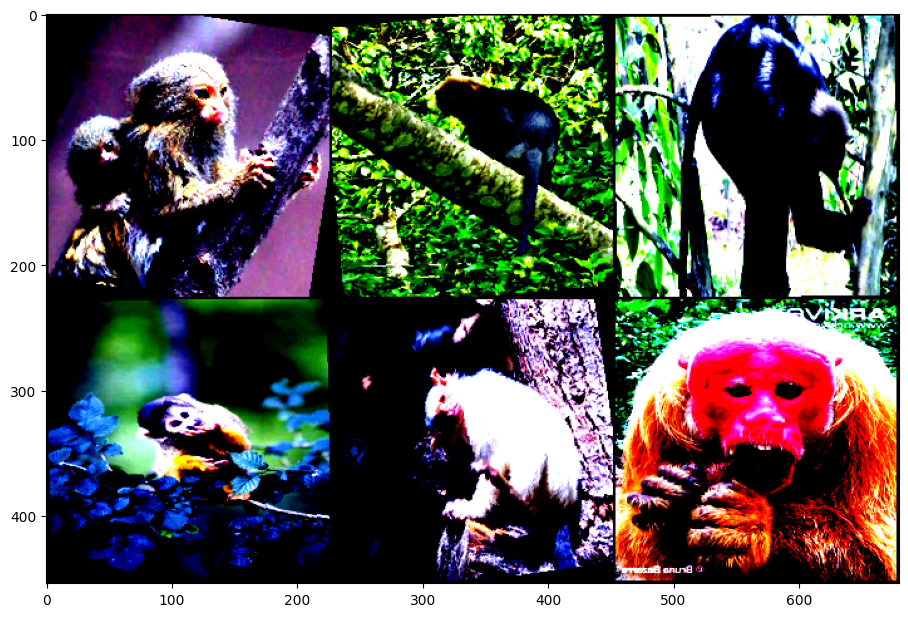

In [13]:
show_transformed_images(train_dataset)

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [15]:
def set_device():
    if torch.cuda.is_available():
        #print('cuda gpu is available')
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)     

In [16]:
set_device()

cuda gpu is available


device(type='cuda', index=0)

In [17]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epoch):
    device = set_device()

    for epoch in range(n_epoch):
        print('Epoch number %d' % (epoch +1))
        model.train()
        running_loss = 0
        running_correct = 0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            
            outputs=model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print(" _Training dataset got %d out of %d images correct (%.3f%%).epoch loss:%.3f " % (running_correct, total, epoch_acc, epoch_loss))

        evaluate_model_on_test_dataset(model, test_loader)
        
    print('finished')
    return model

In [18]:
def evaluate_model_on_test_dataset(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0 
    device  = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs=model(images)
            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted ==labels).sum().item()

    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
    print(" _ testing dataset. got %d out of %d images correctly(%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_acc))

In [19]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained = False)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

cuda gpu is available


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 150)

cuda gpu is available
Epoch number 1
 _Training dataset got 236 out of 1097 images correct (21.513%).epoch loss:2.173 
cuda gpu is available
 _ testing dataset. got 56 out of 272 images correctly(20.588%)
Epoch number 2
 _Training dataset got 387 out of 1097 images correct (35.278%).epoch loss:1.922 
cuda gpu is available
 _ testing dataset. got 68 out of 272 images correctly(25.000%)
Epoch number 3
 _Training dataset got 429 out of 1097 images correct (39.107%).epoch loss:1.761 
cuda gpu is available
 _ testing dataset. got 91 out of 272 images correctly(33.456%)
Epoch number 4



KeyboardInterrupt

